>>> LOADING DATA...
Data Loaded. Active Sales Rows: 844338

--- Evaluating: 1. Raw Data (Naive) ---
Train range: 2013-01-01 -> 2015-06-18 (802,942 rows)
Test  range: 2015-06-19 -> 2015-07-31 (41,396 rows)
Preprocessing...
Training XGBoost (log target = False)...
Done. RMSPE: 0.16692

--- Evaluating: 2. Business Logic Features ---
Train range: 2013-01-01 -> 2015-06-18 (802,942 rows)
Test  range: 2015-06-19 -> 2015-07-31 (41,396 rows)
Preprocessing...
Training XGBoost (log target = True)...
Optimizing correction factor (on TRAIN, not TEST)...
Best factor (from TRAIN): 0.9800
Done. RMSPE: 0.14387

--- Evaluating: 3. Entity Embeddings ---
Train range: 2013-01-01 -> 2015-06-18 (802,942 rows)
Test  range: 2015-06-19 -> 2015-07-31 (41,396 rows)
Preprocessing...


d:\dataviz_proj\processors.py:540: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(self.model_save_path, map_location=self.device)
d:\dataviz_proj\processors.py:540

Training XGBoost (log target = True)...
Optimizing correction factor (on TRAIN, not TEST)...
Best factor (from TRAIN): 0.9860
Done. RMSPE: 0.12478

FINAL LEADERBOARD (RMSPE - Lower is Better)
                               RMSPE Features Log Target
3. Entity Embeddings        0.124781       96       True
2. Business Logic Features  0.143872       20       True
1. Raw Data (Naive)         0.166923       17      False


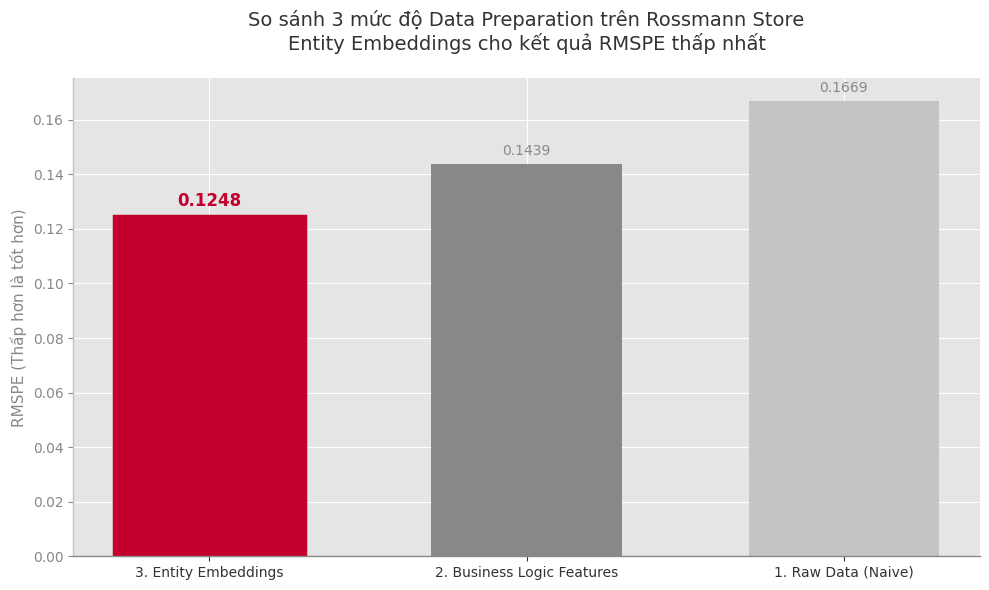

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from evaluator import RossmannComparer
from processors import RawFeatureGenerator, OptimizedFeatureGenerator, EntityEmbeddingFeatureGenerator

ROSSMANN_RED = '#C3002D'
GRAY_NEUTRAL = '#888888'
GRAY_LIGHT   = '#C3C3C3'

%matplotlib inline
plt.style.use('ggplot')

# ==========================================
# 1. LOAD DATA & FIXED PARAMS
# ==========================================
print(">>> LOADING DATA...")
train_df_full = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory=False)
store_df = pd.read_csv('data/store.csv')

train_df_full = train_df_full[(train_df_full['Open'] == 1) & (train_df_full['Sales'] > 0)]
print(f"Data Loaded. Active Sales Rows: {len(train_df_full)}")

FIXED_PARAMS = {
    'objective': 'reg:squarederror',
    'n_estimators': 300,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'n_jobs': -1,
    'random_state': 42
}

comparer = RossmannComparer(
    model_params=FIXED_PARAMS,
    train_df=train_df_full,
    store_df=store_df
)

# ==========================================
# 2. CHẠY THỰC NGHIỆM (3 LEVEL)
# ==========================================

# LEVEL 1: RAW DATA
comparer.evaluate(
    pipeline_name="1. Raw Data (Naive)",
    preprocessor=RawFeatureGenerator(),
    use_log_target=False
)

# LEVEL 2: BUSINESS LOGIC FEATURES
comparer.evaluate(
    pipeline_name="2. Business Logic Features",
    preprocessor=OptimizedFeatureGenerator(),
    use_log_target=True
)

# LEVEL 3: ENTITY EMBEDDINGS
emb_pipeline = EntityEmbeddingFeatureGenerator(
    model_save_path='checkpoints/emb_model_compare.pth',
    epochs=20,
    batch_size=256
)

comparer.evaluate(
    pipeline_name="3. Entity Embeddings",
    preprocessor=emb_pipeline,
    use_log_target=True
)

# ==========================================
# 3. TỔNG HỢP & VẼ BIỂU ĐỒ
# ==========================================

summary = comparer.get_summary()
print("\n" + "="*40)
print("FINAL LEADERBOARD (RMSPE - Lower is Better)")
print("="*40)
print(summary)

plt.figure(figsize=(10, 6))
ax = plt.gca()

bar_colors = []
for name in summary.index:
    if "Entity" in name:
        bar_colors.append(ROSSMANN_RED)
    elif "Business" in name:
        bar_colors.append(GRAY_NEUTRAL)
    else:
        bar_colors.append(GRAY_LIGHT)

bars = ax.bar(summary.index, summary['RMSPE'], color=bar_colors, width=0.6)

ax.set_title(
    "So sánh 3 mức độ Data Preparation trên Rossmann Store\n"
    "Entity Embeddings cho kết quả RMSPE thấp nhất",
    fontsize=14, color='#333333', pad=20
)
ax.set_ylabel("RMSPE (Thấp hơn là tốt hơn)", fontsize=11, color=GRAY_NEUTRAL)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(GRAY_LIGHT)
ax.spines['bottom'].set_color(GRAY_NEUTRAL)
ax.tick_params(axis='x', colors='#333333', rotation=0)
ax.tick_params(axis='y', colors=GRAY_NEUTRAL)

for bar, name, color in zip(bars, summary.index, bar_colors):
    height = bar.get_height()
    is_entity = ("Entity" in name)

    if is_entity:
        bar.set_linewidth(2.5)
        bar.set_edgecolor(ROSSMANN_RED)

    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.002,
        f'{height:.4f}',
        ha='center', va='bottom',
        fontweight='bold' if is_entity else 'normal',
        color=ROSSMANN_RED if is_entity else GRAY_NEUTRAL,
        fontsize=12 if is_entity else 10
    )


plt.tight_layout()
plt.show()


Chọn 3 Store dùng chung cho mọi pipeline: [571 527 843]

=== 1. Raw Data (Naive) ===


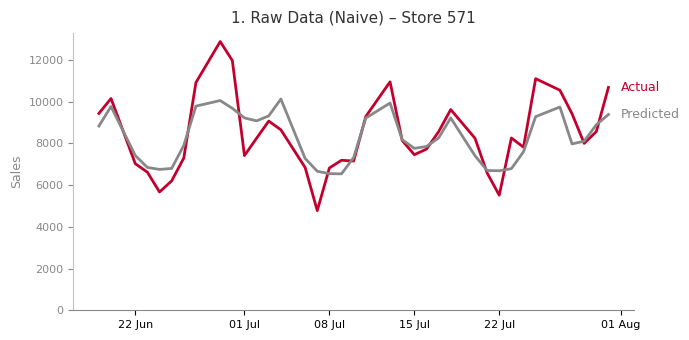

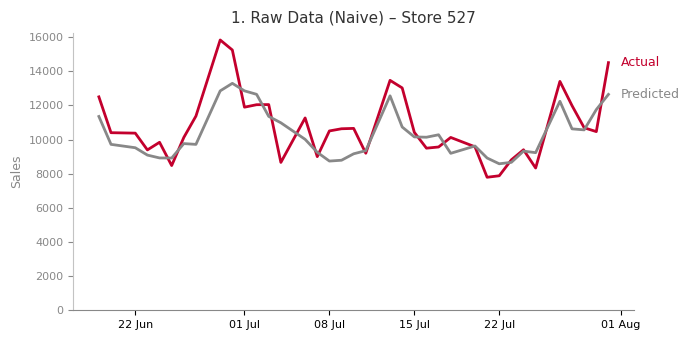

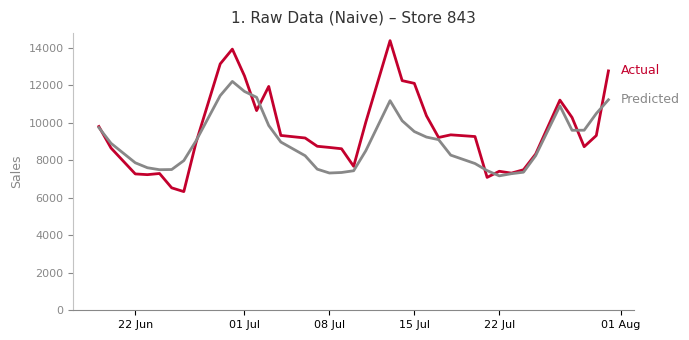


=== 2. Business Logic Features ===


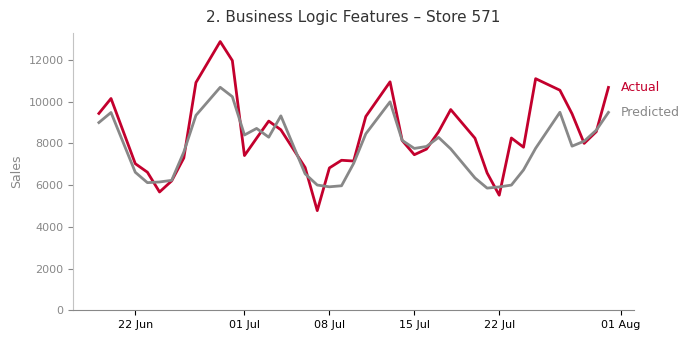

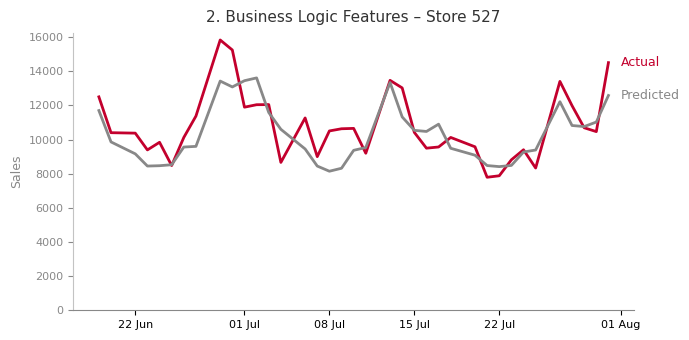

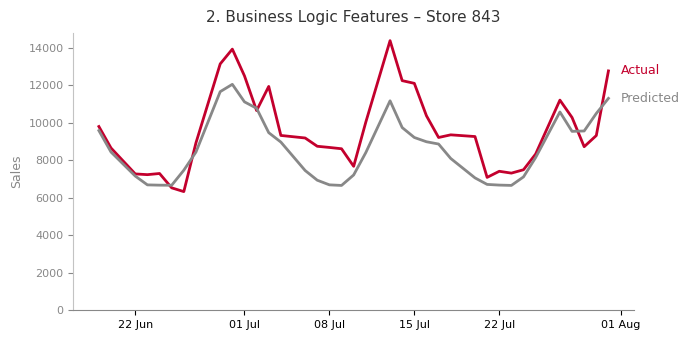


=== 3. Entity Embeddings ===


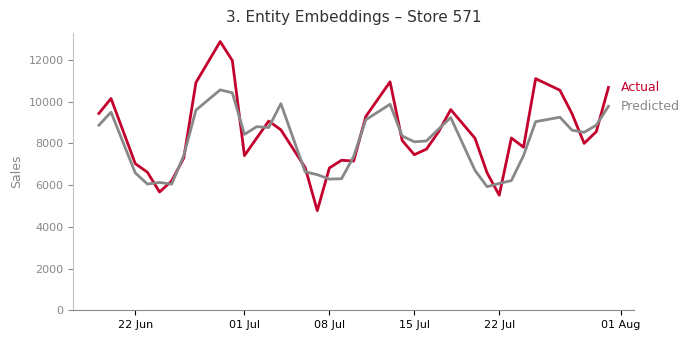

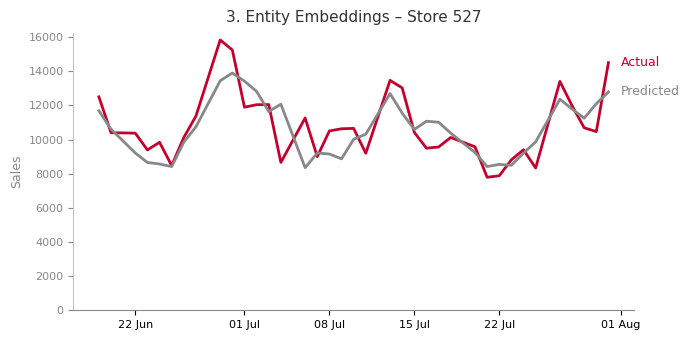

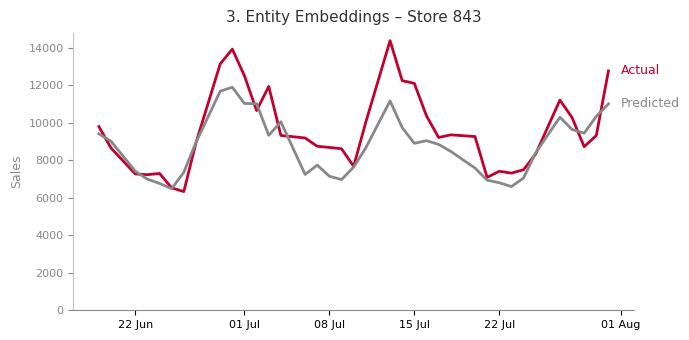

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ROSSMANN_RED = '#C3002D'
GRAY_NEUTRAL = '#888888'
GRAY_LIGHT   = '#C3C3C3'

plt.style.use("default")

# ----------------------------------------------------
# Hàm vẽ 1 store cho 1 pipeline: Actual vs Predicted
# ----------------------------------------------------
def plot_store_series(df_pred, store_id, pipeline_name):
    sub = (
        df_pred[df_pred["Store"] == store_id]
        .sort_values("Date")
        .copy()
    )
    if sub.empty:
        print(f"[WARN] No test data for Store {store_id} in {pipeline_name}")
        return

    fig, ax = plt.subplots(figsize=(7, 3.5))
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # Đường thực tế: ĐỎ ROSSMMANN (nổi bật)
    ax.plot(
        sub["Date"],
        sub["y_true"],
        color=ROSSMANN_RED,
        linewidth=2
    )

    # Đường dự đoán: XÁM, nét đứt
    ax.plot(
        sub["Date"],
        sub["y_pred"],
        color=GRAY_NEUTRAL,
        linewidth=2,
        linestyle="-"
    )

    # -------- Decluttering ----------
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    formatter = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=8)

    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(GRAY_LIGHT)
    ax.spines["bottom"].set_color(GRAY_NEUTRAL)

    ax.tick_params(axis="y", labelsize=8, colors=GRAY_NEUTRAL)
    ax.set_ylim(bottom=0)  
    ax.set_xlabel("", fontsize=9)
    ax.set_ylabel("Sales", fontsize=9, color=GRAY_NEUTRAL)

    ax.set_title(
        f"{pipeline_name} – Store {store_id}",
        fontsize=11,
        color="#333333",
        pad=8
    )

    # Label trực tiếp hai đường
    last_date = sub["Date"].iloc[-1]
    offset_x = pd.Timedelta(days=1)

    ax.text(
        last_date + offset_x,
        sub["y_true"].iloc[-1],
        "Actual",
        color=ROSSMANN_RED,
        fontsize=9,
        va="center",
        ha="left"
    )

    ax.text(
        last_date + offset_x,
        sub["y_pred"].iloc[-1],
        "Predicted",
        color=GRAY_NEUTRAL,
        fontsize=9,
        va="center",
        ha="left"
    )

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# Chọn CHUNG 3 Store cho TẤT CẢ pipeline
# ----------------------------------------------------
rng = np.random.default_rng(1)

any_pipeline_df = next(iter(comparer.predictions_.values()))
store_list = np.sort(any_pipeline_df["Store"].unique())

n_examples = min(3, len(store_list))
chosen_stores = rng.choice(store_list, size=n_examples, replace=False)
print("Chọn 3 Store dùng chung cho mọi pipeline:", chosen_stores)

# ----------------------------------------------------
# Vẽ: với MỖI pipeline, lặp qua 3 store giống nhau
# ----------------------------------------------------A
for pipeline_name, df_pred in comparer.predictions_.items():
    print(f"\n=== {pipeline_name} ===")
    for sid in chosen_stores:
        plot_store_series(df_pred, sid, pipeline_name)


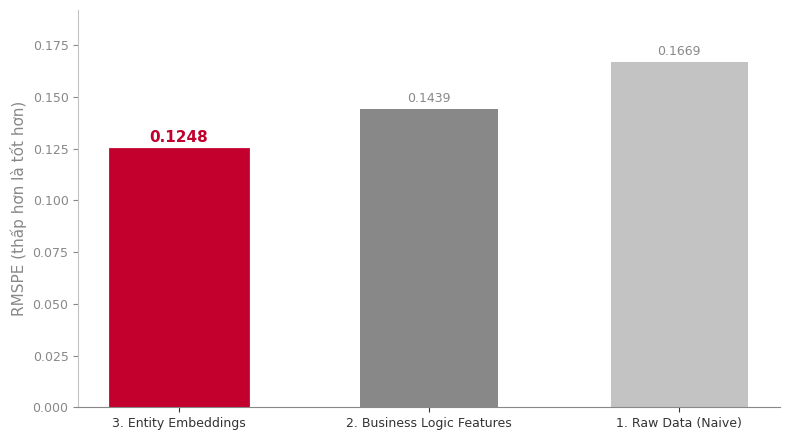

In [7]:

import matplotlib.pyplot as plt
import numpy as np

ROSSMANN_RED = "#C3002D"
GRAY_NEUTRAL = "#888888"
GRAY_LIGHT   = "#C3C3C3"

plt.style.use("default")

# Nếu bạn đã có summary từ comparer.get_summary()
# summary = comparer.get_summary()

# Hoặc dùng trực tiếp:
labels = ["3. Entity Embeddings",
          "2. Business Logic Features",
          "1. Raw Data (Naive)"]
rmspe_vals = np.array([0.1248, 0.1439, 0.1669])

# Màu: mô hình tốt nhất (min RMSPE) = đỏ, còn lại xám
best_idx = rmspe_vals.argmin()
bar_colors = []
for i in range(len(labels)):
    if i == best_idx:
        bar_colors.append(ROSSMANN_RED)
    elif labels[i].startswith("2."):
        bar_colors.append(GRAY_NEUTRAL)
    else:
        bar_colors.append(GRAY_LIGHT)

fig, ax = plt.subplots(figsize=(8, 4.5))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

bars = ax.bar(labels, rmspe_vals, color=bar_colors, width=0.55)

# Trục tung bắt đầu từ 0
ax.set_ylim(0, rmspe_vals.max() * 1.15)

# Tiêu đề gọn
ax.set_title(
    "",
    fontsize=13,
    color="#333333",
    pad=12
)
ax.set_ylabel("RMSPE (thấp hơn là tốt hơn)", fontsize=11, color=GRAY_NEUTRAL)

# Declutter: bỏ grid, border trên/phải
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(GRAY_LIGHT)
ax.spines["bottom"].set_color(GRAY_NEUTRAL)

ax.tick_params(axis="x", colors="#333333", labelsize=9)
ax.tick_params(axis="y", colors=GRAY_NEUTRAL, labelsize=9)

# Label trực tiếp trên cột
for i, bar in enumerate(bars):
    height = bar.get_height()
    is_best = (i == best_idx)

    if is_best:
        bar.set_linewidth(2)
        bar.set_edgecolor(ROSSMANN_RED)

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.002,
        f"{height:.4f}",
        ha="center",
        va="bottom",
        fontsize=11 if is_best else 9,
        fontweight="bold" if is_best else "normal",
        color=ROSSMANN_RED if is_best else GRAY_NEUTRAL
    )

plt.tight_layout()
plt.show()
